<span style="font-family:Papyrus; font-size:3em;" >Estimating Parameter Confidence Intervals With Bootstrapping</span>

This notebook demonstrates the calculations required to do confidence interval constructions.
1. Construct a good model. This means checking that we get good $R^2$ values (or other model quality metrics) for each fold in a cross validation.
1. Compute residuals for the good model.
1. Construct a collection of parameter estimates. That is, for many repetitions
   1. Construct new observations (by using randomly selected residuals)
   1. Estimate parameter values
1. Compute the mean and standard deviation of the parameter estimates
1. Construct the confidence interval

**SOME BUGS**

# Programming Preliminaries

In [1]:
IS_COLAB = False
#
if IS_COLAB:
  !pip install matplotlib
  !pip install numpy
  !pip install tellurium
  !pip install SBstoat
#    
# Constants for standalone notebook
if not IS_COLAB:
    CODE_DIRS = ["/home/ubuntu/advancing-biomedical-models/common"]
    CODE_DIRS.append("/home/ubuntu/SBstoat")
    DATA_DIR = "/home/ubuntu/advancing-biomedical-models/lecture_12"
else:
    from google.colab import drive
    drive.mount('/content/drive')
    CODE_DIRS = ["/content/drive/MyDrive/Modeling_Class/Winter 2021/common"]
    DATA_DIR = "/content/drive/MyDrive/Modeling_Class/Lecture Notes/12_lecture"
import sys
for path in CODE_DIRS:
    sys.path.insert(0, path)
# Other constants
TIME = "time"

In [2]:
%matplotlib inline
import numpy as np
import lmfit   # Fitting lib
import pandas as pd
import matplotlib.pyplot as plt
from SBstoat.modelFitter import ModelFitter
from SBstoat.observationSynthesizer import ObservationSynthesizerRandomizedResiduals, ObservationSynthesizerRandomErrors
from SBstoat.namedTimeseries import NamedTimeseries
import model_fitting as mf

# Model and Data

In [3]:
# Model used in this example
MODEL = """
     A -> B; k1*A
     B -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0.1
     k2 = 0.2
"""
PARAMETERS_TO_FIT = ["k1", "k2"]
PARAMETER_ESTIMATES = ModelFitter.mkParameters(parametersToFit=PARAMETERS_TO_FIT)
PARAMETER_ESTIMATES

name,value,initial value,min,max,vary
k1,5.00000000,5.0,0.00000000,10.0000000,True
k2,5.00000000,5.0,0.00000000,10.0000000,True


In [4]:
# Globals
NUM_POINTS = 30
SIM_TIME= 30
NOISE_STD = 0.3

In [5]:
fittedTS = ModelFitter.runSimulation(roadrunner=MODEL, numPoint=NUM_POINTS, endTime=SIM_TIME, returnDataFrame=False)
synthesizer = ObservationSynthesizerRandomErrors(fittedTS=fittedTS, std=NOISE_STD)
OBS_TS = synthesizer.calculate()
OBS_TS

                  A         B         C
time                                   
0.000000   4.763107  0.127791  0.230178
1.034483   4.615130  0.410116 -0.168190
2.068966   3.834938  1.105666 -0.571971
3.103448   3.040599  0.173583  0.259141
4.137931   3.455802  0.589946  0.546973
5.172414   3.233817  1.184764  0.721569
6.206897   2.880449  1.076058  1.523401
7.241379   2.232698  0.720702  1.379407
8.275862   2.034105  1.216898  1.120953
9.310345   2.298824  0.999331  1.848472
10.344828  2.020215  1.566223  2.358441
11.379310  1.585522  1.227108  2.212744
12.413793  1.482121  1.261457  2.812434
13.448276  1.678309  0.922665  2.884894
14.482759  1.311098  0.698400  2.817709
15.517241  0.707609  1.172169  2.647168
16.551724  0.513839  0.936055  2.974758
17.586207  0.922327  0.899725  3.331519
18.620690  0.752702  0.885580  3.746949
19.655172  0.836918  0.221247  3.480755
20.689655  0.493270  0.179382  3.933335
21.724138 -0.035912  0.878373  3.598822
22.758621  0.808125  0.535151  4.446732


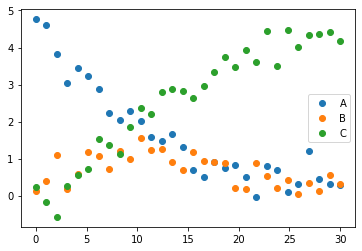

In [6]:
_, ax = plt.subplots(1)
for column in OBS_TS.colnames:
    ax.scatter(OBS_TS[TIME], OBS_TS[column])
_ = plt.legend(OBS_TS.colnames)

# Bootstrapping Workflow

## Construct a good model.
In the following, we use the same model as the synthetic observations. Of course, in practice, you won't know the "true" model.

First, we need to estimate the parameter values to use in our model. To this end, we do a fit on the full set of data.

In [7]:
FITTER = ModelFitter(MODEL, OBS_TS, parametersToFit=["k1", "k2"])
FITTER.fitModel()
FITTED_TS = FITTER.fittedTS
PARAMETER_ESTIMATES = FITTER.params
PARAMETER_ESTIMATES

/home/ubuntu/advancing-biomedical-models/cls/lib/python3.6/site-packages/roadrunner/roadrunner.py:3944: UserWarning:

Simulation requested end point (30.000000000000004) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(0.0, 30.000000000000004, 1001)
  * Setting r.integrator.variable_step_size to 'False'
* Setting 



name,value,standard error,relative error,initial value,min,max,vary
k1,0.09650037,0.00298320,(3.09%),9.494436819824125,0.00000000,10.0000000,True
k2,0.20035793,0.01172726,(5.85%),2.3450700531563,0.00000000,10.0000000,True


In [8]:
print(FITTER.reportFit())

[[Fit Statistics]]
    chi-square         = 7.89515816
    reduced chi-square = 0.08971771
    Akaike info crit   = -215.020399
    Bayesian info crit = -210.020780
[[Variables]]
    k1:  0.09650037 +/- 0.00298320 (3.09%) (init = 9.494437)
    k2:  0.20035793 +/- 0.01172726 (5.85%) (init = 2.34507)
[[Correlations]] (unreported correlations are < 0.100)
    C(k1, k2) = -0.398


**Question**
1. What are the parameter estimates if the NOSE_STD is 0.8?

## Compute the Residuals
Residuals need to be calculated by chemical species since they may be in very different units.

In [9]:
# Note that the residuals for the chemical species differ. Compare the residuals for A (1st col) with
# the residuals for C (3rd col)
columns = FITTED_TS.colnames
RESIDUALS_TS = OBS_TS.copy()  # Create the shape of the residuals
RESIDUALS_TS[columns] -= FITTED_TS[columns]
RESIDUALS_TS

                  A         B         C
time                                   
0.000000  -0.236893  0.127791  0.230178
1.034483   0.090164 -0.018182 -0.214926
2.068966  -0.260124  0.369936 -0.741179
3.103448  -0.665404 -0.775203 -0.086070
4.137931   0.101894 -0.498685 -0.010489
5.172414   0.198554  0.012628 -0.071032
6.206897   0.133557 -0.136657  0.483008
7.241379  -0.253221 -0.500293  0.086321
8.275862  -0.215634  0.011527 -0.423937
9.310345   0.262825 -0.173109  0.056910
10.344828  0.177651  0.438857  0.328370
11.379310 -0.081986  0.152950 -0.045589
12.413793 -0.026963  0.245540  0.337434
13.448276  0.312599 -0.032343  0.205612
14.482759  0.075140 -0.194819 -0.053114
15.517241 -0.410925  0.340286 -0.402416
16.551724 -0.498426  0.164086 -0.241007
17.586207  0.006234  0.185556 -0.038219
18.620690 -0.076356  0.226630  0.234957
19.655172  0.086626 -0.385365 -0.162341
20.689655 -0.185738 -0.377944  0.169669
21.724138 -0.650411  0.367213 -0.275521
22.758621  0.252008  0.067042  0.470958


In [10]:
# The standard deviation of the residuals should be approximately the same as the standard deviation
# of the random noise we injected in the construction of the observations.
np.std(RESIDUALS_TS.flatten())

0.29462017472673324

A validation of our codes and workflow is that the standard deviation of the residuals is close to the standard deviation of the noise used in the observational data.

## Construct a Collection of Parameter Estimates

### Step 3a: Construct Synthetic Observations
We define a function that constructs a set of observations from residuals and a model.

In [11]:
synthesizer = ObservationSynthesizerRandomizedResiduals(fittedTS=FITTED_TS, observedTS=OBS_TS, residualsTS=RESIDUALS_TS)

In [12]:
synthesizer.calculate()

                  A         B         C
time                                   
0.000000   4.636021 -0.385365 -0.275521
1.034483   4.787791  0.114122 -0.245279
2.068966   4.357888  0.899816  0.201224
3.103448   3.055592  0.916443  0.575389
4.137931   2.703497  1.252717  1.040470
5.172414   2.671283  1.336223  0.849511
6.206897   2.753126  1.224242  0.831741
7.241379   2.389984  0.445792  0.551907
8.275862   2.448293  1.010552  2.027899
9.310345   1.625073  0.954971  1.877882
10.344828  1.192154  0.946205  1.789063
11.379310  1.866062  1.109573  2.240468
12.413793  0.843679  1.315363  2.436781
13.448276  0.954785  0.922665  2.470631
14.482759  1.208995  0.960261  2.832604
15.517241  1.959536  0.984832  3.279762
16.551724  1.034322  1.112256  3.445943
17.586207  1.002719  0.867119  2.628559
18.620690  0.330632  0.671578  3.681662
19.655172  0.836918  0.770699  3.951177
20.689655  0.780903  0.568853  3.795681
21.724138  0.203574  0.675245  3.960663
22.758621  0.689674  0.295000  4.205952


In [13]:
# Try running this several times to see how values change.
synthesizer.calculate()

                  A         B         C
time                                   
0.000000   5.016595 -0.018182 -0.741179
1.034483   4.600105  0.613854  0.384170
2.068966   4.272713  0.899816  0.151343
3.103448   3.825926  1.315999  0.673581
4.137931   2.855481  0.951973 -0.008193
5.172414   3.155186  1.183663  0.824616
6.206897   3.059491  1.279757  1.275350
7.241379   2.502513  1.385081  1.084434
8.275862   3.090741  1.024210  1.269370
9.310345   2.122624  0.787075  1.367625
10.344828  1.431640  1.280315  1.976957
11.379310  1.757672  0.892998  1.692678
12.413793  0.843679  0.517232  2.507015
13.448276  1.455874  1.107957  2.987363
14.482759  0.737532  1.263155  2.129644
15.517241  1.124768  0.614414  2.625647
16.551724  1.114159  1.141906  2.650110
17.586207  0.417667  0.336225  3.316624
18.620690  0.845653  0.477789  2.770813
19.655172  0.756526  0.734404  3.240679
20.689655  0.769173  0.685117  4.101099
21.724138  0.866506  0.133216  3.931252
22.758621  0.676040  0.273290  4.205952


### Repeatedly estimate parameter values

In [14]:
def estimateParameters(model, observedTS, parametersToFit, numIteration=10):
    estimateDct = {p: [] for p in parametersToFit}
    # Get the initial estimates
    fitter = ModelFitter(model, observedTS, parametersToFit=parametersToFit)
    fitter.fitModel()
    initialParams = fitter.params
    # Create the observation synthesizer
    synthesizer = ObservationSynthesizerRandomizedResiduals(fittedTS=fitter.fittedTS, observedTS=observedTS)
    # Iterative calculate parameters
    for _ in range(numIteration):
        newObservedTS = synthesizer.calculate()
        newFitter = ModelFitter(model, newObservedTS, parametersToFit=parametersToFit)
        newFitter.fitModel(params=initialParams)
        [estimateDct[p].append(newFitter.params.valuesdict()[p]) for p in parametersToFit]
    return estimateDct

# Tests
numIteration = 5
estimateDct = estimateParameters(MODEL, OBS_TS, PARAMETERS_TO_FIT, numIteration=numIteration)
assert(len(estimateDct[PARAMETERS_TO_FIT[0]]) == len(estimateDct[PARAMETERS_TO_FIT[1]]))
assert(len(estimateDct[PARAMETERS_TO_FIT[0]]) == numIteration)

/home/ubuntu/advancing-biomedical-models/cls/lib/python3.6/site-packages/roadrunner/roadrunner.py:3944: UserWarning:

Simulation requested end point (30.000000000000004) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(0.0, 30.000000000000004, 1001)
  * Setting r.integrator.variable_step_size to 'False'
* Setting 



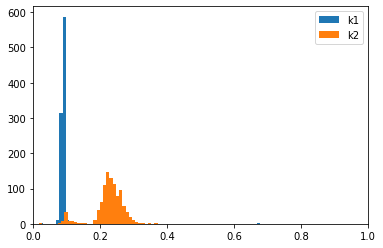

In [16]:
ESTIMATE_DCT = estimateParameters(MODEL, OBS_TS, PARAMETERS_TO_FIT, numIteration=1000)
def plotHist(parameter):
    _ = plt.hist(ESTIMATE_DCT[parameter],bins=1000)
    plt.xlim([0, 1])

for parameter in PARAMETERS_TO_FIT:
    plotHist(parameter)
_ = plt.legend(PARAMETERS_TO_FIT)

**Questions**
1. How do the quality of the parameter estimates change with the number of simulation points? With the simulation time?

## Compute Confidence Intervals

In [ ]:
np.quantile(range(10), [.10, .90])

**Question**
1. Calculate 95% confidence intervals for the parameters.
   1. How many iterations should you use?

In [17]:
# Solution
for parameter in estimateDct.keys():
    quantile = np.quantile(estimateDct[parameter], [0.025, 0.975])
    print("%s: %s" % (parameter, str(quantile)))

k1: [0.09582003 4.09999821]
k2: [0.1029174  0.22152091]


# Exercise

TRUE MODEL:

- A -> B
- A -> C
- B + C -> D

All kinetics are mass action. The kinetics constants are (in order of the reactions): 0.5, 0.5, 1.0. The initial concentration of A is 5. Consider a time course of duration 30 with 20 points.


1. Generate synthetic observations using this model using a normally distributed noise with a standard deviation
of 0.1.
1. Using the true model (the one above), find the $R^2$ values in a cross validation with 4 folds.
1. Construct confidence intervals for the parameters.

In [ ]:
# Model used in this example
new_model = """
     A -> B; k1*A
     A -> C; k2*A
     B + C -> D; k3*B*C
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0.5
     k2 = 0.5
     k3 = 1.0
"""

In [ ]:
# Globals
num_points = 20
sim_time = 30
nose_std = 0.1

In [ ]:
# Create synthetic observational data for this example. This is for demonstration purposes only.
# In practice, you will have observational data from experiments.
obs_data = mf.makeObservations(model=new_model, noise_std=nose_std, num_points=num_points, sim_time=sim_time)

In [ ]:
mf.plotTimeSeries(obs_data, is_scatter=True, columns=['A','B', 'C', 'D'])

In [ ]:
fitted_parameters = mf.fit(obs_data, model=new_model, parameter_estimates=unfitted_parameters,
                           num_points=num_points, sim_time=sim_time)
fitted_parameters

In [ ]:
print(new_model)

In [ ]:
obs_data

In [ ]:
# Construct the matrix of residuals
residuals_matrix = mf.makeResidualsDF(obs_data, model=new_model, parameter_estimates=fitted_parameters, 
                                          num_points=num_points, sim_time=sim_time)
residuals_matrix

In [ ]:
# Do the cross validation for this model. the crossValidate function returns two values: list of
# the parameters (for each fold) and RSQs for each fold.
list_parameters, rsqs = mf.crossValidate(obs_data, model=new_model, parameter_estimates=fitted_parameters, 
                                         num_points=num_points, 
                                         sim_time=sim_time,
                                         num_folds=4)
rsqs

In [ ]:
list_parameters = makeParametersList(new_model, fitted_parameters, residuals_matrix, num_points, sim_time)
list_parameters

In [ ]:
# Here's the result
mf.makeParameterStatistics(list_parameters)

# Bootstrapping With SBstoat